In [12]:
from tkinter import N
from joblib import PrintTime
import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import daytime
import Funciones  
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

In [13]:
#Definir Zona Horaria
tz = 'America/Bogota'
lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
altitude = 50

In [14]:
location = pvlib.location.Location(lat, lon, tz, altitude)

api_key = 'rMYPYAhkiXjb9WUAjQVU728EI59XhF2TeY9ml5cz'
email = 'da.parral@uniandes.edu.co'
elpaso_tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020')

In [31]:
tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
elpaso_tmy.columns = tmy_columns_rename
elpaso_tmy.head()

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed
2020-01-01 06:30:00-05:00,2020,1,1,6,30,25.3,20.0,21.0,19.0,22.0,0.18,998.0,219.0,0.0
2020-01-01 07:30:00-05:00,2020,1,1,7,30,27.9,19.2,109.0,246.0,180.0,0.18,999.0,92.0,0.0
2020-01-01 08:30:00-05:00,2020,1,1,8,30,31.1,18.0,201.0,326.0,361.0,0.18,999.0,144.0,0.1
2020-01-01 09:30:00-05:00,2020,1,1,9,30,33.7,17.2,294.0,333.0,513.0,0.18,999.0,189.0,0.1
2020-01-01 10:30:00-05:00,2020,1,1,10,30,35.6,16.8,373.0,308.0,611.0,0.18,998.0,219.0,0.1


In [32]:
solpos = pvlib.solarposition.get_solarposition(elpaso_tmy.index, lat, lon)
# remove nighttime
elpaso_tmy = elpaso_tmy.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]


In [33]:
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.25)

tracker = tracker.fillna(0)
tracker.head()
airmass = location.get_airmass(times=elpaso_tmy.index, 
                               solar_position=solpos, 
                               model='kastenyoung1989')

airmass.head()
etr_nrel = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpaso_tmy.index, 
                                          method='NREL', 
                                          solar_constant=1361);
surface_albedo = pvlib.irradiance.SURFACE_ALBEDOS['soil']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function
solpos.to_csv(path_or_buf='path2')


In [49]:
poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.5,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=4,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)


C:\Users\dalpt\AppData\Local\Programs\Python\Python37\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python37\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
C:\Users\dalpt\AppData\Local\Programs\Python\Python37\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
C:\Users\dalpt\AppData\Local\Programs\Python\Python37\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
C:\Users\dalpt\AppData\Local\Programs\Python\Python37\lib\site-packages\pvfactors\viewfa

In [35]:
poa_perez = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker.surface_tilt, 
                                            surface_azimuth=tracker.surface_azimuth, 
                                            solar_zenith=solpos.apparent_zenith, 
                                            solar_azimuth=solpos.azimuth, 
                                            dni=elpaso_tmy.dni, 
                                            ghi=elpaso_tmy.ghi, 
                                            dhi=elpaso_tmy.dhi, 
                                            dni_extra=etr_nrel, 
                                            airmass=airmass.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

<AxesSubplot:>

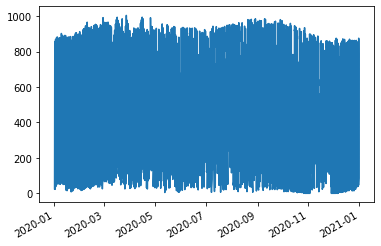

In [19]:

poa_frontabsorb.plot()

<AxesSubplot:>

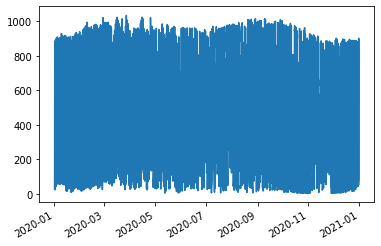

In [20]:
poa_perez.poa_global.plot()

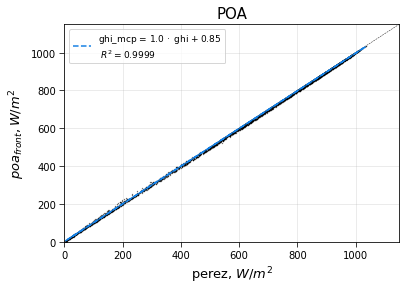

R2:  0.9999
RMSE:  0.42
MAPE:  0.16


In [36]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_front': poa_front})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_front

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('ghi_mcp = ' + 
                  f'{slope.round(2)} $· \:$ ghi $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{front}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

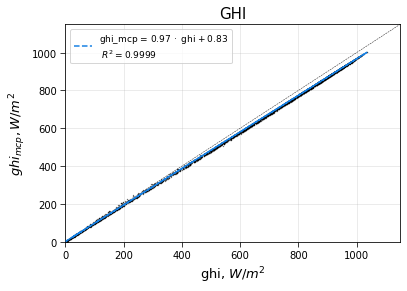

R2:  0.9999
RMSE:  2.23
MAPE:  3.03


In [25]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_frontabsorb': poa_frontabsorb})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_frontabsorb

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('poa_frontabs = ' + 
                  f'{slope.round(2)} $· \:$ perez $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{frontabs}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

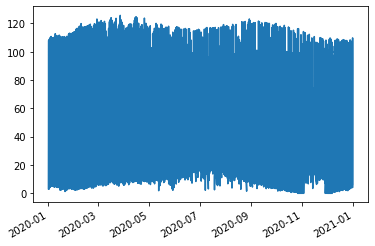

In [39]:

poa_backabsorb.plot()



<AxesSubplot:>

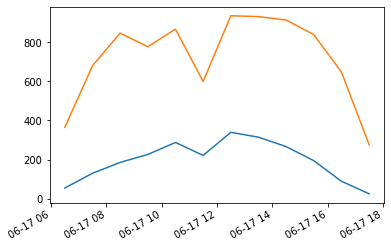

In [50]:
fecha = '2020-06-17 '
poa_1=poa_backabsorb[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']
poa_1.plot()
poa_2.plot()

<AxesSubplot:>

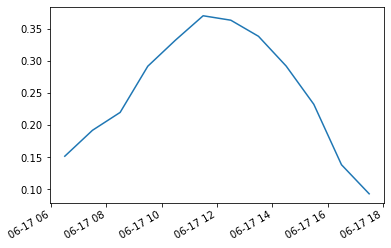

In [53]:
fecha = '2020-06-17 '
poa_1=poa_backabsorb[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']
bg_opt=poa_1.truediv(poa_2)
bg_opt
bg_opt.plot()


# Calculo de la producción energetica total

In [64]:
def irrad_total_bifacial(front,back, bifaciality):
    try:
        x=back.mul(bifaciality)
        irrad=front.add(x)
        return(irrad)
    except: 
        print("irrad_total_bifacial failed")

In [68]:
irrad=irrad_total_bifacial(poa_frontabsorb,
                            poa_backabsorb,0.95)
irrad

2020-01-01 06:30:00-05:00      35.241236
2020-01-01 07:30:00-05:00     416.160577
2020-01-01 08:30:00-05:00     651.879900
2020-01-01 09:30:00-05:00     786.446423
2020-01-01 10:30:00-05:00     851.010281
                                ...     
2020-12-31 13:30:00-05:00    1155.639064
2020-12-31 14:30:00-05:00    1092.327449
2020-12-31 15:30:00-05:00     940.377450
2020-12-31 16:30:00-05:00     653.317243
2020-12-31 17:30:00-05:00      61.936922
Length: 4355, dtype: float64

<AxesSubplot:>

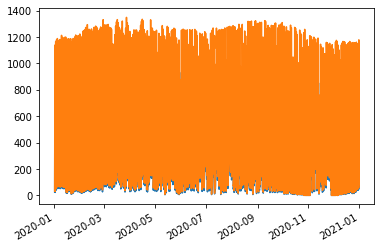

In [69]:
poa_frontabsorb.plot()
irrad.plot()

In [37]:
temp_cell = pvlib.temperature.sapm_cell(poa_global=poa_front, 
                                        temp_air=elpaso_tmy.temp_air, 
                                        wind_speed=elpaso_tmy.wind_speed, 
                                        a=-3.56, 
                                        b=-0.075, 
                                        deltaT=3, 
                                        irrad_ref=1000)
